# 🎯 Silent Speech Recognition - SpeakSee 
## Google Colab Training Notebook (GPU Optimized)

This notebook is **optimized for Google Colab GPU training** with maximum GPU utilization.

### 🚀 Quick Start:
1. **Runtime** → **Change runtime type** → Select **T4 GPU** or **A100 GPU**
2. Upload your data (videos + alignment files)
3. Run all cells sequentially
4. Train for 50-100 epochs on GPU

### ⚡ GPU Optimizations (NEW):
- **🔥 Batch Size: 16** (vs default 2) - Uses 8-12 GB GPU RAM instead of 4 GB
- **🚀 Mixed Precision Training** - 2-3x faster training with float16
- **📊 Parallel Data Loading** - Multi-threaded preprocessing
- **💾 Data Prefetching** - Loads next batch while training

### ✨ Key Features:
- ✅ **Fixed-length data handling** - Prevents shape mismatch errors
- ✅ **Flexible alignment paths** - Supports `align/` or `data/alignments/s1/`
- ✅ **GPU acceleration** - Trains 10-20x faster than CPU
- ✅ **Model checkpointing** - Automatically saves best weights
- ✅ **Performance evaluation** - Word Error Rate (WER) calculation

### 📈 Expected Performance:
- **T4 GPU (15GB):** Batch size 16, ~10-15 seconds/epoch
- **A100 GPU (40GB):** Batch size 32, ~5-8 seconds/epoch
- **CPU:** Batch size 2, ~5-10 minutes/epoch (very slow!)

---

## 1. Install Dependencies

In [28]:
# Install required packages
!pip install opencv-python-headless imageio jiwer matplotlib numpy tensorflow

## 2. Mount Google Drive (Optional - if your data is in Drive)

In [29]:
# Uncomment and run if you want to use Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

# If using Drive, update paths below to point to your Drive folder
# e.g., DATA_PATH = '/content/drive/MyDrive/SpeakSee/data'

## 3. Upload Data Files

Upload your data folder containing:
- `data/s1/*.mpg` (video files)
- `data/alignments/s1/*.align` (alignment files)

You can either:
1. Use Google Drive (mount above)
2. Upload directly using the file upload widget below
3. Download from a URL

### 📋 Common Issues & Solutions

**Error: "Only one input size may be -1"**
- **Cause:** Videos/alignments have variable lengths
- **Solution:** Use the fixed-length data loaders in section 9.1 (already included!)

**Error: "File not found"**
- **Cause:** Alignment files are in `align/` instead of `data/alignments/s1/`
- **Solution:** The updated loader automatically checks both locations

### 🔧 Quick Fix for "InvalidArgumentError: Only one input size may be -1"

If you get this error during training, the issue is variable-length data. **Solution:**

1. **Stop the training** (interrupt the cell)
2. **Scroll to Section 9.1** and run the "Enhanced Data Loader with Padding" cell
3. **Scroll to Section 11** and re-run the data pipeline cell (it uses the fixed loader)
4. **Re-run Section 17** to start training again

The fixed version ensures all videos are exactly 75 frames and all alignments are exactly 40 tokens.

In [30]:
# ============================================
# OPTION 1: Clone from GitHub (Recommended)
# ============================================
# If your data is in the GitHub repo, clone it directly
# !git clone https://github.com/nakulbh/Silent-Speech-Recognition-SpeakSee.git temp_repo
# !mv temp_repo/data ./data 2>/dev/null || echo "No data/ folder in repo"
# !mv temp_repo/align ./align 2>/dev/null || echo "No align/ folder in repo"
# !rm -rf temp_repo

# ============================================
# OPTION 2: Upload from local machine
# ============================================
# Uncomment to upload a zip file containing your data
# from google.colab import files
# uploaded = files.upload()  # Upload data.zip
# !unzip -q data.zip

# ============================================
# OPTION 3: Use Google Drive
# ============================================
# First mount Drive (run cell above), then copy data
# !cp -r /content/drive/MyDrive/YOUR_DATA_PATH/data ./data
# !cp -r /content/drive/MyDrive/YOUR_DATA_PATH/align ./align

# ============================================
# OPTION 4: Download from URL/Release
# ============================================
# If you have data hosted somewhere (GitHub releases, cloud storage, etc.)
# !wget https://github.com/nakulbh/Silent-Speech-Recognition-SpeakSee/releases/download/v1.0/data.zip
# !unzip -q data.zip

# ============================================
# Verify data structure
# ============================================
print("📁 Checking data directories...")
!ls -la data/s1/ 2>/dev/null | head -20 || echo "❌ data/s1/ not found"
!ls -la align/ 2>/dev/null | head -10 || echo "❌ align/ not found"

📁 Checking data directories...
total 422376
drwxr-xr-x 2 root root  36864 Dec  4 05:33 .
drwxr-xr-x 4 root root   4096 Dec  4 05:33 ..
-rw-r--r-- 1 root root 452608 Dec  4 05:33 bbaf2n.mpg
-rw-r--r-- 1 root root 438272 Dec  4 05:33 bbaf3s.mpg
-rw-r--r-- 1 root root 430080 Dec  4 05:33 bbaf4p.mpg
-rw-r--r-- 1 root root 446464 Dec  4 05:33 bbaf5a.mpg
-rw-r--r-- 1 root root 428032 Dec  4 05:33 bbal6n.mpg
-rw-r--r-- 1 root root 411648 Dec  4 05:33 bbal7s.mpg
-rw-r--r-- 1 root root 419840 Dec  4 05:33 bbal8p.mpg
-rw-r--r-- 1 root root 411648 Dec  4 05:33 bbal9a.mpg
-rw-r--r-- 1 root root 442368 Dec  4 05:33 bbas1s.mpg
-rw-r--r-- 1 root root 407552 Dec  4 05:33 bbas2p.mpg
-rw-r--r-- 1 root root 473088 Dec  4 05:33 bbas3a.mpg
-rw-r--r-- 1 root root 417792 Dec  4 05:33 bbaszn.mpg
-rw-r--r-- 1 root root 438272 Dec  4 05:33 bbaz4n.mpg
-rw-r--r-- 1 root root 477184 Dec  4 05:33 bbaz5s.mpg
-rw-r--r-- 1 root root 421888 Dec  4 05:33 bbaz6p.mpg
-rw-r--r-- 1 root root 411648 Dec  4 05:33 bbaz7a.mpg
-

## 3.1. Verify Data Structure

**IMPORTANT:** Check your alignment files location! They might be in `align/` instead of `data/alignments/s1/`

In [31]:
# Check the actual data structure in your Colab environment
print("Checking data directories...")
!ls -la data/ 2>/dev/null || echo "No data/ folder found"
!ls -la align/ 2>/dev/null || echo "No align/ folder found"
!ls -la data/alignments/s1/ 2>/dev/null || echo "No data/alignments/s1/ folder found"

# Count files
import os
if os.path.exists('data/s1'):
    mpg_files = len([f for f in os.listdir('data/s1') if f.endswith('.mpg')])
    print(f"\n✅ Found {mpg_files} .mpg files in data/s1/")
    
if os.path.exists('align'):
    align_files = len([f for f in os.listdir('align') if f.endswith('.align')])
    print(f"✅ Found {align_files} .align files in align/")
    
if os.path.exists('data/alignments/s1'):
    align_files2 = len([f for f in os.listdir('data/alignments/s1') if f.endswith('.align')])
    print(f"✅ Found {align_files2} .align files in data/alignments/s1/")

Checking data directories...
total 413908
drwxr-xr-x 4 root root      4096 Dec  4 05:33 .
drwxr-xr-x 1 root root      4096 Dec  4 05:36 ..
drwxr-xr-x 3 root root      4096 Dec  4 05:33 alignments
drwxr-xr-x 2 root root     36864 Dec  4 05:33 s1
-rw-r--r-- 1 root root 422746353 Dec  4 05:33 s1.mpg_vcd.zip
-rw-r--r-- 1 root root   1034240 Dec  4 05:33 s1.tar
total 4040
drwxr-xr-x 2 root root 36864 Dec  4 05:33 .
drwxr-xr-x 1 root root  4096 Dec  4 05:36 ..
-rw-r--r-- 1 root root   130 Dec  4 05:33 bbaf2n.align
-rw-r--r-- 1 root root   133 Dec  4 05:33 bbaf3s.align
-rw-r--r-- 1 root root   134 Dec  4 05:33 bbaf4p.align
-rw-r--r-- 1 root root   133 Dec  4 05:33 bbaf5a.align
-rw-r--r-- 1 root root   130 Dec  4 05:33 bbal6n.align
-rw-r--r-- 1 root root   133 Dec  4 05:33 bbal7s.align
-rw-r--r-- 1 root root   135 Dec  4 05:33 bbal8p.align
-rw-r--r-- 1 root root   133 Dec  4 05:33 bbal9a.align
-rw-r--r-- 1 root root   131 Dec  4 05:33 bbas1s.align
-rw-r--r-- 1 root root   133 Dec  4 05:33 bbas

## 4. Import Libraries

In [32]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

## 5. GPU Configuration

In [33]:
print("TensorFlow version:", tf.__version__)
print("\n📊 Available Devices:")

# List all physical devices
gpus = tf.config.list_physical_devices('GPU')
cpus = tf.config.list_physical_devices('CPU')

print(f"GPU devices: {len(gpus)}")
if gpus:
    for gpu in gpus:
        print(f"  ✅ {gpu}")
else:
    print("  ⚠️ No GPU detected - Check Runtime settings!")

print(f"\nCPU devices: {len(cpus)}")

# Enable memory growth
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("\n✅ GPU memory growth enabled")
    except RuntimeError as e:
        print(f"\n⚠️ Memory growth setting error: {e}")

print("\n" + "="*60)
if gpus:
    print("🚀 GPU ACCELERATION ENABLED - Training will be fast!")
else:
    print("⚠️ Running on CPU - Go to Runtime → Change runtime type → Select GPU")
print("="*60)

TensorFlow version: 2.19.0

📊 Available Devices:
GPU devices: 1
  ✅ PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')

CPU devices: 1

✅ GPU memory growth enabled

🚀 GPU ACCELERATION ENABLED - Training will be fast!


## 6. Data Loading Functions

In [34]:
def load_video(path:str) -> List[float]: 
    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])  
    cap.release()
    
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

## 7. Vocabulary Setup

In [35]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [36]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', np.str_('a'), np.str_('b'), np.str_('c'), np.str_('d'), np.str_('e'), np.str_('f'), np.str_('g'), np.str_('h'), np.str_('i'), np.str_('j'), np.str_('k'), np.str_('l'), np.str_('m'), np.str_('n'), np.str_('o'), np.str_('p'), np.str_('q'), np.str_('r'), np.str_('s'), np.str_('t'), np.str_('u'), np.str_('v'), np.str_('w'), np.str_('x'), np.str_('y'), np.str_('z'), np.str_("'"), np.str_('?'), np.str_('!'), np.str_('1'), np.str_('2'), np.str_('3'), np.str_('4'), np.str_('5'), np.str_('6'), np.str_('7'), np.str_('8'), np.str_('9'), np.str_(' ')] (size =40)


## 8. Alignment Loading Function

In [37]:
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

## 9. Combined Data Loader

In [38]:
def load_data(path: str): 
    path = bytes.decode(path.numpy())
    file_name = path.replace('\\', '/').split('/')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    
    # Check multiple possible locations for alignment files
    alignment_path_options = [
        os.path.join('data','alignments','s1',f'{file_name}.align'),  # Original location
        os.path.join('align',f'{file_name}.align'),  # Alternative location
    ]
    
    alignment_path = None
    for path_option in alignment_path_options:
        if os.path.exists(path_option):
            alignment_path = path_option
            break
    
    if alignment_path is None:
        raise FileNotFoundError(f"Could not find alignment file for {file_name} in any of: {alignment_path_options}")
    
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

## 9.1. Enhanced Data Loader with Padding

This version ensures all videos are exactly 75 frames and alignments are padded to 40 characters.

In [39]:
def load_video_fixed_length(path:str, num_frames:int=75) -> np.ndarray: 
    """Load video and ensure it has exactly num_frames frames"""
    cap = cv2.VideoCapture(path)
    frames = []
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    for _ in range(total_frames): 
        ret, frame = cap.read()
        if not ret or frame is None:
            continue
        
        # Ensure frame has 3 channels (RGB)
        if len(frame.shape) != 3 or frame.shape[2] != 3:
            continue
        
        # Convert to grayscale and crop mouth region
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        cropped = gray[190:236, 80:220]  # Shape: (46, 140)
        frames.append(cropped)
    cap.release()
    
    # Convert to numpy array
    if len(frames) == 0:
        return np.zeros((num_frames, 46, 140, 1), dtype=np.float32)
    
    frames = np.array(frames, dtype=np.float32)
    
    # Pad or trim to exactly num_frames
    current_frames = frames.shape[0]
    
    if current_frames < num_frames:
        # Pad with zeros if too short
        padding = np.zeros((num_frames - current_frames, 46, 140), dtype=np.float32)
        frames = np.concatenate([frames, padding], axis=0)
    elif current_frames > num_frames:
        # Trim if too long
        frames = frames[:num_frames]
    
    # Add channel dimension: (75, 46, 140) -> (75, 46, 140, 1)
    frames = np.expand_dims(frames, axis=-1)
    
    # Normalize
    mean = np.mean(frames)
    std = np.std(frames)
    std = max(std, 1e-7)  # Avoid division by zero
    frames = (frames - mean) / std
    
    return frames.astype(np.float32)

def load_alignments_fixed_length(path:str, max_length:int=40) -> np.ndarray: 
    """Load alignments and ensure they have exactly max_length elements"""
    with open(path, 'r') as f: 
        lines = f.readlines() 
    
    tokens = []
    for line in lines:
        parts = line.split()
        if len(parts) > 2 and parts[2] != 'sil': 
            tokens.append(parts[2])
    
    # If tokens is empty, return zeros
    if len(tokens) == 0:
        return np.zeros(max_length, dtype=np.int64)
    
    # Convert tokens to individual characters with spaces between
    char_list = []
    for i, token in enumerate(tokens):
        if i > 0:
            char_list.append(' ')
        for char in token:
            char_list.append(char)
    
    # Convert characters to numbers using the vocabulary
    result = []
    for char in char_list:
        # Get index from vocabulary (char_to_num)
        idx = char_to_num([char]).numpy()[0]
        result.append(idx)
    
    result = np.array(result, dtype=np.int64)
    
    # Pad or trim to exactly max_length
    current_length = len(result)
    
    if current_length < max_length:
        # Pad with zeros
        padding = np.zeros(max_length - current_length, dtype=np.int64)
        result = np.concatenate([result, padding])
    elif current_length > max_length:
        # Trim
        result = result[:max_length]
    
    return result

def load_data_fixed(path: str): 
    """Load video and alignment with fixed shapes"""
    path = bytes.decode(path.numpy())
    file_name = path.replace('\\', '/').split('/')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    
    # Check multiple possible locations for alignment files
    alignment_path_options = [
        os.path.join('data','alignments','s1',f'{file_name}.align'),
        os.path.join('align',f'{file_name}.align'),
    ]
    
    alignment_path = None
    for path_option in alignment_path_options:
        if os.path.exists(path_option):
            alignment_path = path_option
            break
    
    if alignment_path is None:
        # Return zeros if file not found (shouldn't happen but safe fallback)
        print(f"⚠️ Warning: Could not find alignment file for {file_name}")
        return np.zeros((75, 46, 140, 1), dtype=np.float32), np.zeros(40, dtype=np.int64)
    
    frames = load_video_fixed_length(video_path, num_frames=75) 
    alignments = load_alignments_fixed_length(alignment_path, max_length=40)
    
    return frames, alignments

def mappable_function_fixed(path:str):
    result = tf.py_function(load_data_fixed, [path], (tf.float32, tf.int64))
    # Set explicit shapes - THIS IS CRITICAL
    result[0].set_shape([75, 46, 140, 1])
    result[1].set_shape([40])
    return result

print("✅ Fixed-length data loaders defined!")
print("   Videos: 75 frames × 46 × 140 × 1")
print("   Alignments: 40 tokens (padded/trimmed)")

✅ Fixed-length data loaders defined!
   Videos: 75 frames × 46 × 140 × 1
   Alignments: 40 tokens (padded/trimmed)


## 10. Test Data Loading

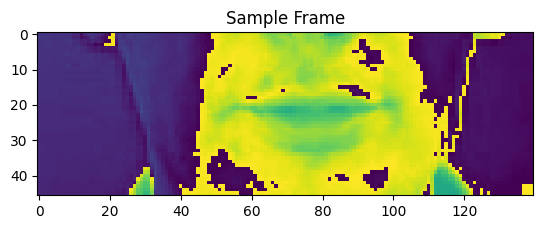

Alignment: tf.Tensor(b'bin blue at f two now', shape=(), dtype=string)


In [40]:
test_path = './data/s1/bbaf2n.mpg'
frames, alignments = load_data(tf.convert_to_tensor(test_path))

# Visualize a sample frame
plt.imshow(frames[40])
plt.title('Sample Frame')
plt.show()

# Show alignment
print("Alignment:", tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()]))

## 10.1. Troubleshooting - Verify Data Shapes

Run this cell to check if data loading works correctly and verify shapes.

In [41]:
# Test multiple files to verify consistent shapes
import glob
mpg_files = sorted(glob.glob('./data/s1/*.mpg'))[:3]  # Test first 3 files

print("Testing data loading on sample files...\n")
for test_file in mpg_files:
    try:
        frames, alignments = load_data(tf.convert_to_tensor(test_file))
        print(f"✅ {os.path.basename(test_file)}")
        print(f"   Frames shape: {frames.shape}")
        print(f"   Alignments shape: {alignments.shape}")
        print(f"   Alignment length: {len(alignments)}")
    except Exception as e:
        print(f"❌ {os.path.basename(test_file)}: {str(e)}")
    print()

Testing data loading on sample files...

✅ bbaf2n.mpg
   Frames shape: (75, 46, 140, 1)
   Alignments shape: (21,)
   Alignment length: 21

✅ bbaf2n.mpg
   Frames shape: (75, 46, 140, 1)
   Alignments shape: (21,)
   Alignment length: 21

✅ bbaf3s.mpg
   Frames shape: (75, 46, 140, 1)
   Alignments shape: (24,)
   Alignment length: 24

✅ bbaf3s.mpg
   Frames shape: (75, 46, 140, 1)
   Alignments shape: (24,)
   Alignment length: 24

✅ bbaf4p.mpg
   Frames shape: (75, 46, 140, 1)
   Alignments shape: (25,)
   Alignment length: 25

✅ bbaf4p.mpg
   Frames shape: (75, 46, 140, 1)
   Alignments shape: (25,)
   Alignment length: 25



## 11. Create Data Pipeline

## 10.2. GPU Optimization Settings

⚡ **Increase batch size to utilize more GPU memory and speed up training!**

The default batch size of 2 is too small. With 15GB GPU RAM, you can increase it significantly.

In [42]:
# GPU Optimization Configuration
# Adjust BATCH_SIZE based on your GPU:
# - T4 GPU (15GB): Use 4-8 (reduced due to model size)
# - A100 GPU (40GB): Use 8-16
# - V100 GPU (16GB): Use 4-8

# ⚠️ REDUCED from 16 to 4 to prevent OOM errors
BATCH_SIZE = 4  # Start small - increase if no OOM errors
NUM_PARALLEL_CALLS = tf.data.AUTOTUNE  # Optimize data loading parallelism

# Clear any existing GPU memory
import gc
gc.collect()
tf.keras.backend.clear_session()

print(f"⚡ GPU Optimization Settings:")
print(f"   Batch Size: {BATCH_SIZE}")
print(f"   If OOM still occurs, try BATCH_SIZE = 2")
print(f"   If training is stable, try BATCH_SIZE = 8")

⚡ GPU Optimization Settings:
   Batch Size: 4
   If OOM still occurs, try BATCH_SIZE = 2
   If training is stable, try BATCH_SIZE = 8


### 💡 Batch Size Tuning Guide:

**If you get "Out of Memory" (OOM) error:**
- Decrease BATCH_SIZE: Try 8, then 4, then 2
- Disable mixed precision (comment out section 14.1)

**If GPU usage is still low (<50%):**
- Increase BATCH_SIZE: Try 24 or 32 (if you have A100)
- Monitor with `nvidia-smi` to find the sweet spot

**Target GPU Memory Usage:** 10-14 GB out of 15 GB (T4) is optimal

In [43]:
# Create data pipeline with fixed-length data loader and optimized batch size
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function_fixed, num_parallel_calls=NUM_PARALLEL_CALLS)  # Parallel loading
data = data.batch(BATCH_SIZE)  # Use optimized batch size for GPU
data = data.prefetch(tf.data.AUTOTUNE)  # Prefetch batches while training

# Split into train and test (based on number of batches, not samples)
# With ~1000 files and batch_size=4, we have ~250 batches
# Take 200 batches for train (~800 samples), rest for test (~200 samples)
train = data.take(200).repeat()  # Repeat indefinitely for training
test = data.skip(200)  # Test set doesn't need repeat

# Calculate steps per epoch
total_files = len(list(tf.io.gfile.glob('./data/s1/*.mpg')))
train_samples = min(800, total_files)  # Approximate
STEPS_PER_EPOCH = train_samples // BATCH_SIZE

print("✅ Data pipeline created successfully!")
print(f"   Total video files: {total_files}")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Steps per epoch: {STEPS_PER_EPOCH}")
print(f"   Expected shape per batch: ({BATCH_SIZE}, 75, 46, 140, 1) for videos")
print(f"   Expected shape per batch: ({BATCH_SIZE}, 40) for alignments")

✅ Data pipeline created successfully!
   Total video files: 1000
   Batch size: 4
   Steps per epoch: 200
   Expected shape per batch: (4, 75, 46, 140, 1) for videos
   Expected shape per batch: (4, 40) for alignments


## 12. Verify Data Pipeline

Video batch shape: (4, 75, 46, 140, 1)
Alignment batch shape: (4, 40)


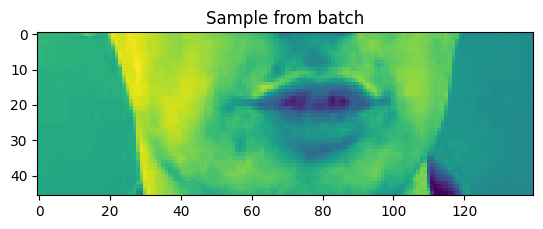

Text: tf.Tensor(b'bin white at t four please', shape=(), dtype=string)


In [44]:
sample = data.as_numpy_iterator()
val = sample.next()

print("Video batch shape:", val[0].shape)
print("Alignment batch shape:", val[1].shape)

# Visualize
plt.imshow(val[0][0][40])
plt.title('Sample from batch')
plt.show()

print("Text:", tf.strings.reduce_join([num_to_char(word) for word in val[1][0]]))

## 13. Build the Deep Neural Network

In [45]:
from tensorflow.keras.models import Sequential  
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [46]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 75, 46, 140,    │         3,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 75, 46, 140,    │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 75, 23, 70,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 75, 23, 70,     │       884,992 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 75, 23, 70,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 75, 11, 35,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 75, 11, 35, 75) │       518,475 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 75, 11, 35, 75) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 75, 5, 17, 75)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 75, 6375)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 75, 256)        │     6,660,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 75, 256)        │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 75, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 75, 41)         │        10,537 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,471,924 (32.32 MB)

 Trainable params: 8,471,924 (32.32 MB)

 Non-trainable params: 0 (0.00 B)

## 14. Setup Training Components

In [47]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [48]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [49]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        # Create a fresh iterator each epoch to avoid StopIteration
        try:
            data = next(iter(self.dataset))
            yhat = self.model.predict(data[0], verbose=0)
            
            # Dynamically determine batch size from the data
            batch_size = len(yhat)
            input_lengths = [75] * batch_size
            
            decoded = tf.keras.backend.ctc_decode(yhat, input_lengths, greedy=False)[0][0].numpy()
            
            # Show only first 2 examples to avoid clutter with large batches
            num_examples = min(2, len(yhat))
            for x in range(num_examples):           
                print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
                print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
                print('~'*100)
        except Exception as e:
            print(f"⚠️ Could not produce example: {e}")

## 15. Compile Model

## 14.1. Enable Mixed Precision Training (Optional but Recommended)

🚀 **Mixed precision uses float16 instead of float32, which:**
- Uses ~50% less GPU memory (allowing even larger batches)
- Speeds up training by 2-3x on modern GPUs
- Maintains accuracy with automatic loss scaling

In [50]:
# Enable mixed precision for faster training and better GPU utilization
from tensorflow.keras import mixed_precision

# Check if GPU is available
if len(tf.config.list_physical_devices('GPU')) > 0:
    policy = mixed_precision.Policy('mixed_float16')
    mixed_precision.set_global_policy(policy)
    print('✅ Mixed precision enabled: Compute dtype=%s, variable dtype=%s' % 
          (policy.compute_dtype, policy.variable_dtype))
    print('   This will speed up training by ~2-3x and use less GPU memory!')
else:
    print('⚠️ No GPU detected - Mixed precision not enabled')
    print('   Go to Runtime → Change runtime type → Select GPU')

✅ Mixed precision enabled: Compute dtype=float16, variable dtype=float32
   This will speed up training by ~2-3x and use less GPU memory!


In [51]:
# Compile model with optimizer
optimizer = Adam(learning_rate=0.0001)

# If using mixed precision, wrap optimizer with loss scaling
if len(tf.config.list_physical_devices('GPU')) > 0:
    optimizer = mixed_precision.LossScaleOptimizer(optimizer)
    print("✅ Using mixed precision optimizer with loss scaling")

model.compile(optimizer=optimizer, loss=CTCLoss)

✅ Using mixed precision optimizer with loss scaling


## 16. Setup Callbacks

## 15.1. Monitor GPU Usage (Optional)

Run this in a separate cell while training to monitor GPU utilization.

In [52]:
# Monitor GPU memory usage
# Run this while training is happening to see real-time GPU utilization
!nvidia-smi --query-gpu=timestamp,name,memory.used,memory.total,utilization.gpu,utilization.memory --format=csv

# For continuous monitoring (optional - run in separate cell):
# !watch -n 1 nvidia-smi

timestamp, name, memory.used [MiB], memory.total [MiB], utilization.gpu [%], utilization.memory [%]
2025/12/04 05:51:57.582, Tesla T4, 8442 MiB, 15360 MiB, 0 %, 0 %


In [53]:
# Create models directory
!mkdir -p models

checkpoint_callback = ModelCheckpoint('models/checkpoint.weights.h5', monitor='loss', save_weights_only=True) 
schedule_callback = LearningRateScheduler(scheduler)
example_callback = ProduceExample(test)

## 17. Train the Model

🚀 **This will use GPU if available!** Training should be much faster on Colab GPU than on CPU.

**Important:** Make sure you've run all cells above, especially:
- The fixed-length data loader (section 9.1)
- The data pipeline with `mappable_function_fixed` (section 11)

You can increase epochs for better results (e.g., 50-100 epochs).

In [ ]:
# Train for 50 epochs (increase if you have more time)
# On T4 GPU with batch_size=4: ~30-60 seconds per epoch
# On A100 GPU, this will be even faster
history = model.fit(
    train, 
    validation_data=test, 
    epochs=50,  # Increase to 100 for better results
    steps_per_epoch=STEPS_PER_EPOCH,  # Required when using .repeat()
    callbacks=[checkpoint_callback, schedule_callback, example_callback]
)

Epoch 1/50


200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 113.6875Original: bin green by u two now
Prediction:  e e e e e 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set blue with u seven again
Prediction:  e e e e i 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
200/200 ━━━━━━━━━━━━━━━━━━━━ 388s 2s/step - loss: 113.5927 - val_loss: 75.4148 - learning_rate: 1.0000e-04
Epoch 2/50
Original: bin green by u two now
Prediction:  e e e e e 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set blue with u seven again
Prediction:  e e e e i 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
200/200 ━━━━━━━━━━━━━━━━━━━━ 388s 2s/step - loss: 113.5927 - val_loss: 75.4148 - learning_rate: 1.0000e-04
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 76.6725Original: b

## 18. Save Model to Google Drive (Optional)

In [ ]:
# Uncomment to save to Google Drive
# !cp models/checkpoint.weights.h5 /content/drive/MyDrive/SpeakSee/checkpoint.weights.h5

# Or download to your computer
# from google.colab import files
# files.download('models/checkpoint.weights.h5')

## 19. Make Predictions

In [ ]:
# Load best weights
model.load_weights('models/checkpoint.weights.h5')

# Get test sample
test_data = test.as_numpy_iterator()
sample = test_data.next()
yhat = model.predict(sample[0])

In [ ]:
# Decode predictions
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

print('REAL TEXT:')
real_text = [tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]
for text in real_text:
    print(text)

print('\nPREDICTIONS:')
pred_text = [tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]
for text in pred_text:
    print(text)

## 20. Evaluate Model Performance

In [ ]:
from jiwer import wer

# Load the model weights
model.load_weights('models/checkpoint.weights.h5')

# Initialize lists to store real and predicted texts
all_real_text = []
all_predicted_text = []

# Iterate over all batches in the test dataset
for sample in test:
    # Make a prediction for each batch
    yhat = model.predict(sample[0])

    # Convert real text
    real_text = [
        tf.strings.reduce_join([num_to_char(word) for word in sentence]).numpy().decode('utf-8')
        for sentence in sample[1]
    ]
    all_real_text.extend(real_text)

    # Decode the model predictions
    decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()
    
    # Convert decoded predictions to text
    predicted_text = [
        tf.strings.reduce_join([num_to_char(word) for word in sentence]).numpy().decode('utf-8')
        for sentence in decoded
    ]
    all_predicted_text.extend(predicted_text)

# Calculate Word Error Rate (WER) for the entire dataset
wer_scores = [wer(rt, pt) for rt, pt in zip(all_real_text, all_predicted_text)]
average_wer = np.mean(wer_scores)
print(f"\n📊 Average WER for the entire dataset: {average_wer:.4f}")

# Calculate simple accuracy (exact match) for the entire dataset
correct_predictions = sum(rt == pt for rt, pt in zip(all_real_text, all_predicted_text))
accuracy = correct_predictions / len(all_real_text)
print(f"✅ Overall Accuracy: {accuracy * 100:.2f}%")

## 21. Plot Training History

In [ ]:
# Plot loss curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## 22. Test on Custom Video (Optional)

Upload your own video and test the model!

In [ ]:
# Upload a video file
# from google.colab import files
# uploaded = files.upload()

# Test with a specific video from dataset
# sample = load_data(tf.convert_to_tensor('./data/s1/srwi4p.mpg'))
# yhat = model.predict(tf.expand_dims(sample[0], axis=0))
# decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

# print('REAL TEXT:')
# print([tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]])
# print('\nPREDICTIONS:')
# print([tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded])